In [1]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('talk')
sns.set_style('white')

# Hands-on Activity 22.2: Gaussian Process Regression with Noise

## Objectives

+ Perform Gaussian process regression with measurement noise

## References

+ [Chapter 3 from C.E. Rasmussen's textbook on Gaussian processes](http://www.gaussianprocess.org/gpml/chapters/RW2.pdf)


## Example: Gaussian process regression in 1D with fixed hyper-parameters and noise

Let's generate some synthetic 1D data to work with:

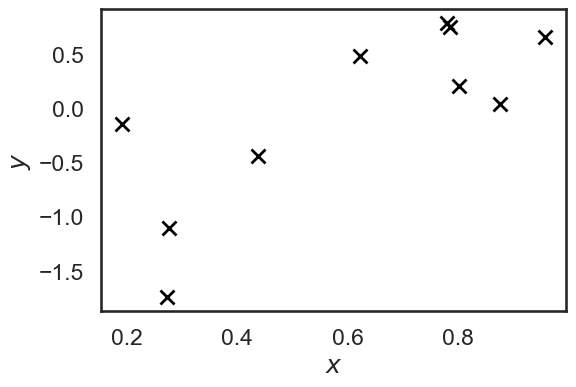

In [2]:
# Fixing the seed so that we all see the same data
np.random.seed(1234)
n = 10
# The inputs are in [0, 1]
X = np.random.rand(n, 1) # Needs to be an n x 1 vector
# The outputs are given from a function plus some noise
# The standard deviation of the noise is:
sigma = 0.4
# The true function that we will try to identify
f_true = lambda x: -np.cos(np.pi * x) + np.sin(4. * np.pi * x)
# Some data to train on
Y = f_true(X) + sigma * np.random.randn(X.shape[0], 1)
# Let's visualize the data
fig, ax = plt.subplots(dpi=100)
ax.plot(X, Y, 'kx', markersize=10, markeredgewidth=2)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$');

In [3]:
# Now, we will get started with the regression
# First, import GPy
import GPy
# Second, pick a kernel. Let's pick a squared exponential (RBF = Radial Basis Function)
k = GPy.kern.RBF(1) # The parameter here is the dimension of the input (here 1)
# Let's print the kernel object to see what it includes:
print(k)

  rbf.         |  value  |  constraints  |  priors
  variance     |    1.0  |      +ve      |        
  lengthscale  |    1.0  |      +ve      |        


The ``variance`` of the kernel is one. This seems reasonable.
Let's leave it like that.
The ``lengthscale`` seems to big.
Let's change it to something reasonable (based on our expectations):

In [4]:
k.lengthscale = 0.1
print(k)

  rbf.         |  value  |  constraints  |  priors
  variance     |    1.0  |      +ve      |        
  lengthscale  |    0.1  |      +ve      |        


There is a possibility to choose a mean function, but for simplicity we are going to pick a zero mean function:
$$
m(x) = 0.
$$
Now we put together the GP regression model as follows:

In [5]:
gpm = GPy.models.GPRegression(X, Y, k) # It is input, output, kernel

This model is automatically assuming that the likelihood is Gaussian (you can modify it if you wish).
Where do can you find the $\sigma^2$ parameter specifying the likelihood noise? Here it is:

In [6]:
print(gpm)


Name : GP regression
Objective : 13.15046970174311
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |  value  |  constraints  |  priors
  rbf.variance             |    1.0  |      +ve      |        
  rbf.lengthscale          |    0.1  |      +ve      |        
  Gaussian_noise.variance  |    1.0  |      +ve      |        


We will talk about the meaning of all that later. For now, let's just fix the noise variance to something reasonable (actually the correct value):

In [7]:
gpm.likelihood.variance = sigma ** 2
print(gpm)


Name : GP regression
Objective : 10.178171187043075
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                value  |  constraints  |  priors
  rbf.variance             |                  1.0  |      +ve      |        
  rbf.lengthscale          |                  0.1  |      +ve      |        
  Gaussian_noise.variance  |  0.16000000000000003  |      +ve      |        


That's it. We have now specified the model completely.
The posterior GP is completely defined.
Where is the posterior mean $m_n(x)$ and variance $\sigma_n^2(x)$? You can get them like this:

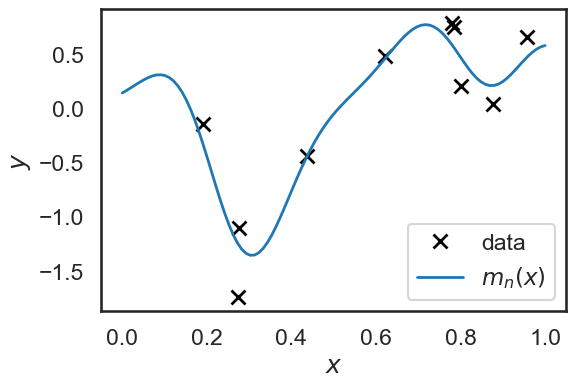

In [8]:
# First the mean on some test points
x_star = np.linspace(0, 1, 100)[:, None] # This is needed to turn the array into a column vector
m_star, v_star = gpm.predict(x_star)
# Let's plot the mean first
fig, ax = plt.subplots(dpi=100)
ax.plot(X, Y, 'kx', markersize=10, markeredgewidth=2, label='data')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.plot(x_star, m_star, lw=2, label='$m_n(x)$')
plt.legend(loc='best');

Extracting the variance is a bit more involved.
Just a tiny bit though.
This is because ``v_star`` returned by ``gpm.predict`` is not exactly $\sigma_n^2(x)$.
It is actually $\sigma_n^2(x) + \sigma^2$ and not just $\sigma_n^2(x)$.
Here, see it:

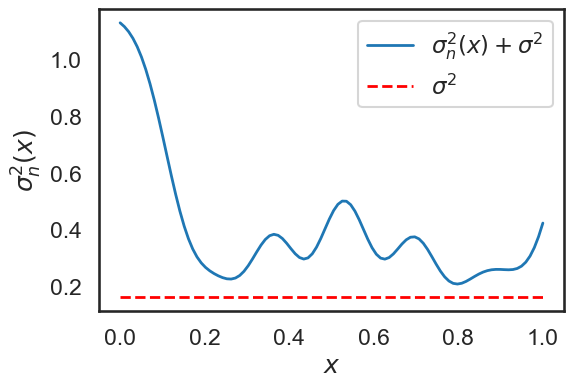

In [9]:
# Now the variance on the same test points
fig, ax = plt.subplots(dpi=100)
ax.plot(x_star, v_star, lw=2, label='$\sigma_n^2(x) + \sigma^2$')
ax.plot(x_star, gpm.likelihood.variance * np.ones(x_star.shape[0]), 'r--', lw=2, label='$\sigma^2$')
ax.set_xlabel('$x$')
ax.set_ylabel('$\sigma_n^2(x)$')
plt.legend(loc='best');

Notice that the variance is small wherever we have an observation.
It is not, however, exactly, $\sigma^2$.
It will become exactly $\sigma^2$ in the limit of many observations.

Having the posterior mean and variance, we can derive 95\% predictive intervals for $f(x^*)$ and $y^*$.
For $f(x^*)$ these are:
$$
m_n(\mathbf{x}^*)) - 2\sigma_n(\mathbf{x}^*) \le f(\mathbf{x}^*) \le m_n(\mathbf{x}^*)) + 2\sigma_n(\mathbf{x}^*).
$$
Let's plot this:

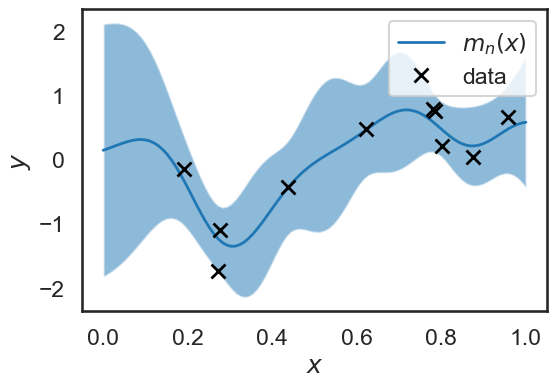

In [10]:
fig, ax = plt.subplots(dpi=100)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
f_lower = m_star - 2.0 * np.sqrt(v_star - gpm.likelihood.variance)
f_upper = m_star + 2.0 * np.sqrt(v_star - gpm.likelihood.variance)
ax.fill_between(x_star.flatten(), f_lower.flatten(), f_upper.flatten(), alpha=0.5)
ax.plot(x_star, m_star, lw=2, label='$m_n(x)$')
ax.plot(X, Y, 'kx', markersize=10, markeredgewidth=2, label='data')
plt.legend(loc='best');

Now, on the same plot, let's superimpose our predictive error bar about $y^*$.
This is:
$$
m_n(\mathbf{x}^*)) - 2\sqrt{\sigma_n^2(\mathbf{x}^*)+\sigma^2}\le f(\mathbf{x}^*) \le m_n(\mathbf{x}^*)) + 2\sqrt{\sigma_n(\mathbf{x}^*) + \sigma^2}.
$$
Let's use red color for this:

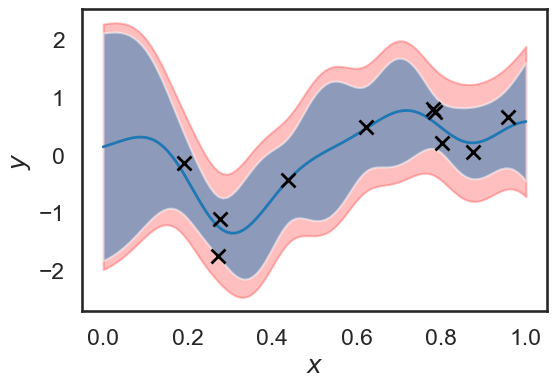

In [11]:
fig, ax = plt.subplots(dpi=100)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
f_lower = m_star - 2.0 * np.sqrt(v_star - gpm.likelihood.variance)
f_upper = m_star + 2.0 * np.sqrt(v_star - gpm.likelihood.variance)
y_lower = m_star - 2.0 * np.sqrt(v_star)
y_upper = m_star + 2.0 * np.sqrt(v_star)
ax.fill_between(x_star.flatten(), y_lower.flatten(), y_upper.flatten(), color='red', alpha=0.25, label='$y^*$ 95% pred.')
ax.fill_between(x_star.flatten(), f_lower.flatten(), f_upper.flatten(), alpha=0.5, label='$f(\mathbf{x}^*)$ 95% pred.')
ax.plot(x_star, m_star, lw=2, label='$m_n(x)$')
ax.plot(X, Y, 'kx', markersize=10, markeredgewidth=2, label='data')
#plt.legend(loc='best');

Let's also put the correct function there for comparison:

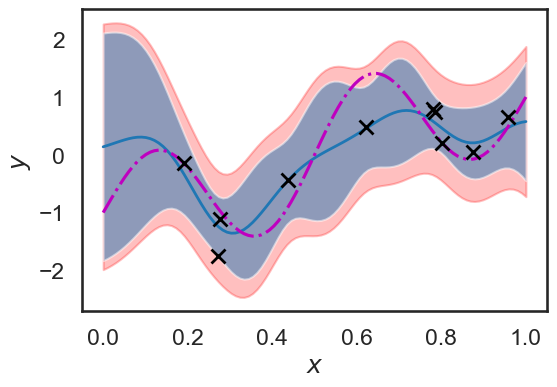

In [12]:
fig, ax = plt.subplots(dpi=100)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
f_lower = m_star - 2.0 * np.sqrt(v_star - gpm.likelihood.variance)
f_upper = m_star + 2.0 * np.sqrt(v_star - gpm.likelihood.variance)
y_lower = m_star - 2.0 * np.sqrt(v_star)
y_upper = m_star + 2.0 * np.sqrt(v_star)
ax.fill_between(x_star.flatten(), y_lower.flatten(), y_upper.flatten(), color='red', alpha=0.25, label='$y^*$ 95% pred.')
ax.fill_between(x_star.flatten(), f_lower.flatten(), f_upper.flatten(), alpha=0.5, label='$f(\mathbf{x}^*)$ 95% pred.')
ax.plot(x_star, m_star, lw=2, label='$m_n(x)$')
ax.plot(x_star, f_true(x_star), 'm-.', label='True function')
ax.plot(X, Y, 'kx', markersize=10, markeredgewidth=2, label='data');
#plt.legend(loc='best');

You see that the true function is almost entirely within the blue bounds.
It is ok that it is a little bit off, becuase these are 95% prediction intervals.
About 5% of the function can be off.

Let's now take some samples from the posterior:

In [13]:
# Here is how you take the samples
f_post_samples = gpm.posterior_samples_f(x_star, 10) # Test points, how many samples you want
# Here is the size of f_post_samples
print(f_post_samples.shape)

(100, 1, 10)


This is ``test points x number of outputs (1 here) x number of samples``.
Let's plot them along with the data and the truth:

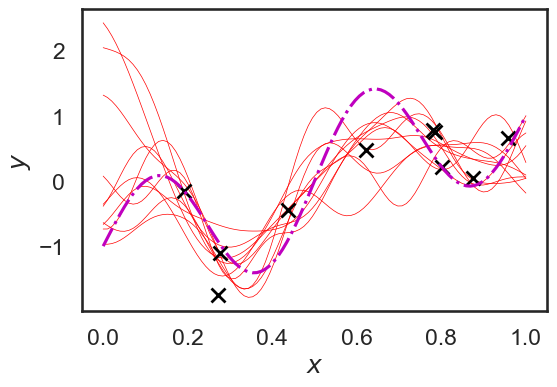

In [14]:
fig, ax = plt.subplots(dpi=100)
ax.plot(x_star, f_post_samples[:, 0, :], 'r', lw=0.5)
ax.plot(X, Y, 'kx', markersize=10, markeredgewidth=2, label='data');
ax.plot(x_star, f_true(x_star), 'm-.', label='True function')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$');

The following interactive function regenerates the figures above allowing you to experiment with various choices of the hyperparameters.

In [15]:
from ipywidgets import interact_manual

def analyze_and_plot_gp_ex1(kern_variance=1.0, kern_lengthscale=0.1, like_variance=0.4):
    """
    Performs GP regression with given kernel variance, lengthcale and likelihood variance.
    """
    #k = GPy.kern.RBF(1)
    k = GPy.kern.Matern32(1)
    gp_model = GPy.models.GPRegression(X, Y, k)
    # Set the parameters
    gp_model.kern.variance = kern_variance
    gp_model.kern.lengthscale = kern_lengthscale
    gp_model.likelihood.variance = like_variance
    # Print model for sanity check
    print(gp_model)
    # Pick test points
    x_star = np.linspace(0, 1, 100)[:, None]
    # Get posterior mean and variance
    m_star, v_star = gp_model.predict(x_star)
    # Plot 1: Mean and 95% predictive interval
    fig1, ax1 = plt.subplots()
    ax1.set_xlabel('$x$')
    ax1.set_ylabel('$y$')
    f_lower = m_star - 2.0 * np.sqrt(v_star - gp_model.likelihood.variance)
    f_upper = m_star + 2.0 * np.sqrt(v_star - gp_model.likelihood.variance)
    y_lower = m_star - 2.0 * np.sqrt(v_star)
    y_upper = m_star + 2.0 * np.sqrt(v_star)
    ax1.fill_between(x_star.flatten(), y_lower.flatten(), y_upper.flatten(), color='red', alpha=0.25, label='$y^*$ 95% pred.')
    ax1.fill_between(x_star.flatten(), f_lower.flatten(), f_upper.flatten(), alpha=0.5, label='$f(\mathbf{x}^*)$ 95% pred.')
    ax1.plot(x_star, m_star, lw=2, label='$m_n(x)$')
    ax1.plot(x_star, f_true(x_star), 'm-.', label='True function')
    ax1.plot(X, Y, 'kx', markersize=10, markeredgewidth=2, label='data')
    #plt.legend(loc='best');
    
    # Plot 2: Data plus posterior samples
    fig2, ax2 = plt.subplots()
    f_post_samples = gp_model.posterior_samples_f(x_star, 10)
    ax2.plot(x_star, f_post_samples[:, 0, :], 'r', lw=0.5)
    ax2.plot(X, Y, 'kx', markersize=10, markeredgewidth=2, label='data');
    ax2.plot(x_star, f_true(x_star), 'm-.', label='True function')
    ax2.set_xlabel('$x$')
    ax2.set_ylabel('$y$')
    #plt.legend(loc='best');
    
interact_manual(analyze_and_plot_gp_ex1,
            kern_variance=(0.01, 10.0, 0.01),
            kern_lengthscale=(0.01, 1.0, 0.01),
            like_variance=(0.01, 1.0, 0.01));

interactive(children=(FloatSlider(value=1.0, description='kern_variance', max=10.0, min=0.01, step=0.01), Floa…

## Diagnostics: How do you know if the fit is good?

To objective test the resulting model we need a *validation dataset* consisting of inputs:
$$
\mathbf{x}^v_{1:n^v} = \left(\mathbf{x}^v_1,\dots,\mathbf{x}^v_{n^v}\right),
$$
and corresponding, observed outputs:
$$
\mathbf{y}^v_{1:n^v} = \left(y^v_1,\dots,y^v_{n^v}\right).
$$
We will use this validation dataset to define some diagnostics.
Let's do it directly through the 1D example above.
First, we generate some validation data:

In [16]:
n_v = 100
X_v = np.random.rand(n_v)[:, None]
Y_v = f_true(X_v) + sigma * np.random.randn(n_v, 1)

#### Point-predictions

Point-predictions only use $m_n\left(\mathbf{x}^v_i\right)$.
Of course, when there is a lot of noise, they are not very useful.
But let's look at what we get anyway.
(In the questions section I will ask you to reduce the noise and repeat).

The simplest thing we can do is to compare $y^v_i$ to $m_n\left(\mathbf{x}^v_i\right)$.
We start with the *mean square error*:
$$
\operatorname{MSE} := \frac{1}{n^v}\sum_{i=1}^{n^v}\left[y^v_i-m_n\left(\mathbf{x}^v_i\right)\right]^2.
$$

In [17]:
m_v, v_v = gpm.predict(X_v)
mse = np.mean((Y_v - m_v) ** 2)
print('MSE = {0:1.2f}'.format(mse))

MSE = 0.32


This is not very intuitive though.
An somewhat intuitive measure is [coefficient of determination](https://en.wikipedia.org/wiki/Coefficient_of_determination) also known as $R^2$, *R squared*.
It is defined as:
$$
R^2 = 1 - \frac{\sum_{i=1}^{n^v}\left[y_i^v - m_n(\mathbf{x}_i^v)\right]^2}{\sum_{i=1}^{n^v}\left[y_i^v-\bar{y}^v\right]^2},
$$
where $\bar{y}^v$ is the mean of the observed data:
$$
\bar{y}^v = \frac{1}{n^v}\sum_{i=1}^{n^v}y_i^v.
$$
The interpretation of $R^2$, and take this with a grain of salt, is that it gives the percentage of variance of the data explained by the model.
A score of $R^2=1$, is a perfect fit.
In our data we get:

In [18]:
R2 = 1.0 - np.sum((Y_v - m_v) ** 2) / np.sum((Y_v - np.mean(Y_v)) ** 2)
print('R2 = {0:1.2f}'.format(R2))

R2 = 0.58


Finally, on point-predictions, we can simply plot the predictions vs the observations:

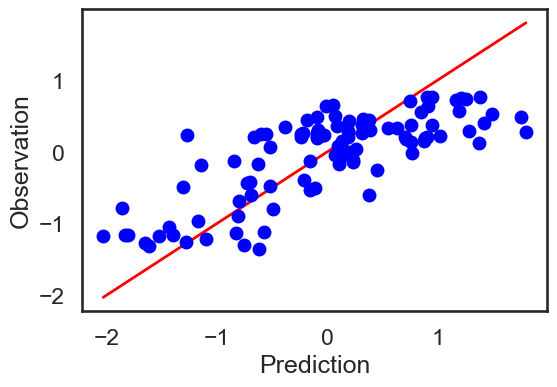

In [19]:
fig, ax = plt.subplots(dpi=100)
y_range = np.linspace(Y_v.min(), Y_v.max(), 50)
ax.plot(y_range, y_range, 'r', lw=2)
ax.plot(Y_v, m_v, 'bo')
ax.set_xlabel('Prediction')
ax.set_ylabel('Observation');

### Statistical diagnostics

Statistical diagnostics compare the predictive distribution to the distribution of the validation dataset.
The way to start, are the standarized errors defined by:
$$
e_i = \frac{y_i^v - m_n\left(\mathbf{x}^v_i\right)}{\sigma_n\left(\mathbf{x}^v_i\right)}.
$$
Now, if our model is correct, the standarized errors must be distributed as a standard normal $N(0,1)$ (why?).
There are various plots that you can do to test that.
First, the histogram of the standarized errors:

Text(0.5, 0, 'Std. error')

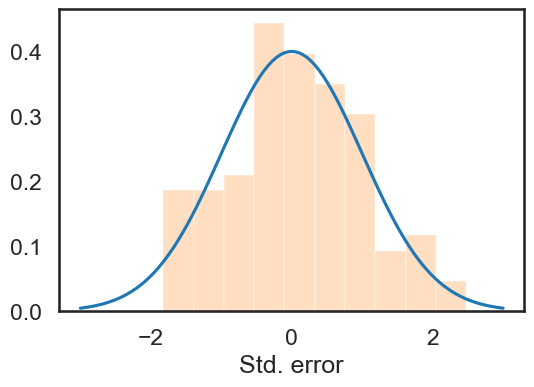

In [20]:
s_v = np.sqrt(v_v)
e = (Y_v - m_v) / s_v
fig, ax = plt.subplots(dpi=100)
zs = np.linspace(-3.0, 3.0, 100)
ax.plot(zs, st.norm.pdf(zs))
ax.hist(e, density=True, alpha=0.25)
ax.set_xlabel('Std. error')

Close, but not perfect.
Another common plot is this:

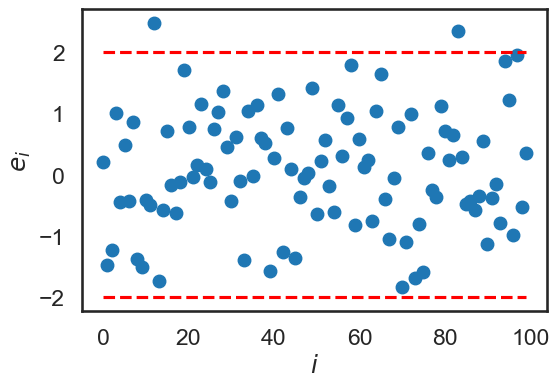

In [21]:
fig, ax = plt.subplots(dpi=100)
ax.plot(e, 'o')
ax.plot(np.arange(e.shape[0]), 2.0 * np.ones(e.shape[0]), 'r--')
ax.plot(np.arange(e.shape[0]), -2.0 * np.ones(e.shape[0]), 'r--')
ax.set_xlabel('$i$')
ax.set_ylabel('$e_i$');

Where the red lines indicate the 95% quantiles of the standard normal.
This  means that if 5\% of the errors are inside, then we are good to go.

Yet another plot yielding the same information is the q-q plot comparing the empirical quantiles of the standarized errors to what they are supposed to be, i.e., to the quantiles of $N(0,1)$:

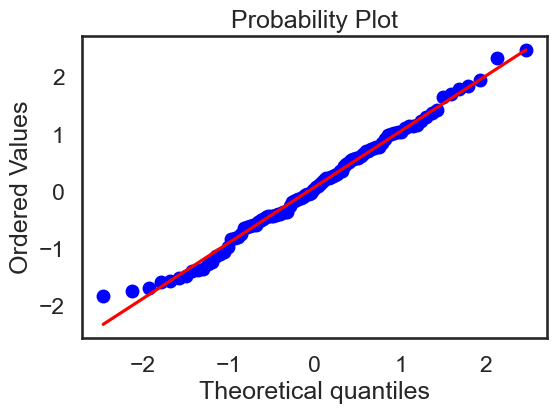

In [22]:
fig, ax = plt.subplots(dpi=100)
st.probplot(e.flatten(), dist=st.norm, plot=ax);

### Note on Gaussian process diagnostics

For a more detailed description of GP regression diagnostics, please see this [paper](https://www.jstor.org/stable/40586652).

### Questions

In the interactive tool above:

+ Experiment with differnet lengthscales for the kernel. You need to click on ``Run Interact`` for the code to run.
What happens to the posterior mean and the 95% predictive error bar as the lengthscale increases (decreases)?

+ Experiment with difference likelihood variances. What happens for very big variances? What happens for very small variances?

+ Experiment with different kernel variances. This the $s^2$ parameter of the squared exponential covariance function. It specifies our prior variance about the function values. What is its effect?

+ Imagine that, as it would be the case in reality, you do not know the true function. How would you pick the correct values for the hyperparameters specifying the kernel?

+ Try some other kernels. Edit the function ``analyze_and_plot_gp_ex1`` and change the line ``k = GPy.kern.RBF(1)`` to ``k = GPy.kern.Matern52(1)``. This is a kernel that is less regular than the RBF. What do you observe?
Then try ``k = GPy.kern.Matern32(1)``. Then ``k = GPy.kern.Exponential(1)``. The last one is continuous but nowhere differentiable.
How can you pick the right kernel?

+ Experiment with larger number of training points $n$. Are the models becoming better according to the metrics we defined above?

+ Experiment with smaller measurement noises $\sigma$. What do you observe? Which diagnostics make sense for very small $\sigma$'s?